# **LendingClub Loan Default Prediction** 

### **Author: Indu R**

### **Project Description:**

This project focuses on predicting loan default using the LendingClub dataset. We will begin by
exploring LendingClub’s business model to understand the importance of default prediction in the peer-to-peer
lending ecosystem. Using the dataset, we will perform bivariate analysis of predictors, build a
classification model to predict defaults, identify the top predictors, and evaluate model performance using
standard classification metrics.

### **Project Objectives:**

- Analyse LendingClub’s business model and its relevance to credit risk prediction.
- Explore and perform bivariate analysis between predictors and loan default outcomes.
- Build and implement a classification model to predict loan defaults.
- Evaluate model performance using appropriate metrics and interpret key predictors.

### **Introduction**

- LendingClub is a peer-to-peer (P2P) lending platform that connects borrowers seeking personal loans with investors looking to earn returns.
- It operates by evaluating borrowers’ creditworthiness using financial and demographic information, and assigns risk grades to each loan.
- Investors can choose loans to fund based on the risk and expected return, creating a marketplace for lending.
- The platform earns revenue through origination fees charged to borrowers and service fees from investors.
- By efficiently matching borrowers and lenders, LendingClub provides an alternative to traditional banks while managing credit risk through careful loan assessment.

### **Step 1: Import Libraries**

In [20]:
import warnings
warnings.filterwarnings("ignore")

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

### **Step 2: Load the Dataset**

In [21]:
df = pd.read_csv("Lending_Club_Loan_Data_Sep2025.csv")
print("Original Shape:", df.shape)
df.head()

Original Shape: (39717, 109)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,NaN,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,NaN,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,AIR RESOURCES BOARD,10+ years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1075269,1311441,5000,5000,5000.0,36 months,7.90%,156.46,Veolia Transportaton,3 years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1072053,1288686,3000,3000,3000.0,36 months,18.64%,109.43,MKC Accounting,9 years,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### **Step 3: Inspect key columns and loan_status (target creation)**

In [22]:
print("loan_status unique values and counts:")
print(df['loan_status'].value_counts(dropna=False))

# Map loan_status -> binary default:
# Conservative mapping: 'Charged Off' and 'Default' as default (1). 'Fully Paid' as non-default (0).
default_positive = ['Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Late (31-120 days)']
df['default'] = df['loan_status'].apply(lambda x: 1 if x in default_positive else 0)

print("Default rate:", df['default'].mean())

loan_status unique values and counts:
loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64
Default rate: 0.14167736737417227


### **Step 4: Data dictionary guided cleaning decisions**

In [23]:
id_like = [c for c in ['id','member_id','url','desc','title'] if c in df.columns]
print("Dropping identifier/free-text columns:", id_like)
df = df.drop(columns=id_like, errors='ignore')

# Show the dictionary entry for a couple of columns to illustrate how to reference it:
def show_dict_for(col):
    rows = data_dict[data_dict.apply(lambda r: col.lower() in str(r).lower(), axis=1)]
    # Slightly permissive search: print rows where column mentioned in the first 3 cols
    print("Dictionary top rows that mention:", col)
    display(data_dict[data_dict.columns.intersection(['Field Name','Definition','Description'])].head(10))

Dropping identifier/free-text columns: ['id', 'member_id', 'url', 'desc', 'title']


### **Step 5:  Choose predictors carefully**

In [24]:
candidate_predictors = [
    'loan_amnt','term','int_rate','installment','grade','sub_grade','emp_length',
    'home_ownership','annual_inc','verification_status','purpose','addr_state','dti',
    'open_acc','pub_rec','revol_bal','revol_util','total_acc','issue_d','earliest_cr_line'
]
predictors = [c for c in candidate_predictors if c in df.columns]
print("Predictors available:", predictors)

Predictors available: ['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'issue_d', 'earliest_cr_line']


### **Step 6: Cleaning and feature engineering**

In [25]:
# 6.1 Numeric conversions & cleaning
for c in ['int_rate','revol_util','annual_inc','dti']:
    if c in df.columns:
        # remove % and commas then convert
        df[c] = df[c].astype(str).str.replace('%','').str.replace(',','')
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Justification: int_rate, revol_util, dti, annual_inc are directly linked to borrower capacity & cost -> impute, not drop.

# 6.2 emp_length -> numeric
if 'emp_length' in df.columns:
    df['emp_length'] = df['emp_length'].astype(str).str.replace('years','').str.replace('year','').str.replace('+','').str.replace('<','').str.replace('n/a','0')
    df['emp_length'] = df['emp_length'].str.extract('(\d+)').astype(float)
    # Filling missing with median (important signal)
    df['emp_length'] = df['emp_length'].fillna(df['emp_length'].median())

# 6.3 issue_d and earliest_cr_line -> derive years / credit age
if 'issue_d' in df.columns:
    df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')
    df['issue_year'] = df['issue_d'].dt.year
if 'earliest_cr_line' in df.columns:
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
    # credit_age = issue_year - earliest_cr_line_year
    if 'issue_year' in df.columns:
        df['earliest_cr_year'] = df['earliest_cr_line'].dt.year
        df['credit_age'] = df['issue_year'] - df['earliest_cr_year']
        df['credit_age'] = df['credit_age'].fillna(df['credit_age'].median())
    else:
        df['earliest_cr_year'] = df['earliest_cr_line'].dt.year
        df['credit_age'] = (pd.Timestamp.now().year - df['earliest_cr_year']).fillna(df['earliest_cr_year'].median())

# 6.4 Imputation for important numeric fields
for c in ['annual_inc','int_rate','revol_util','dti','loan_amnt']:
    if c in df.columns:
        med = df[c].median()
        df[c] = df[c].fillna(med)
        print(f"Imputed missing {c} with median = {med:.2f} (Reason: column important per dictionary — preserves signal)")

# 6.5 Drop extremely sparse columns (>50% missing) unless dictionary says crucial
missing_frac = df.isna().mean().sort_values(ascending=False)
to_drop_sparse = missing_frac[missing_frac > 0.5].index.tolist()
df = df.drop(columns=to_drop_sparse, errors='ignore')
print("Dropped very sparse columns:", to_drop_sparse)

# 6.6 Remove other columns that are not predictive (free text etc.)
# We already removed id/title/desc. If there are other identifiers like 'url', drop them.
for c in ['url','policy_code','member_id','funded_amnt','funded_amnt_inv']:
    if c in df.columns:
        df = df.drop(columns=[c], errors='ignore')
        print("Dropped", c, "as non-model identifiers or duplicates.")

Imputed missing annual_inc with median = 59000.00 (Reason: column important per dictionary — preserves signal)
Imputed missing int_rate with median = 11.86 (Reason: column important per dictionary — preserves signal)
Imputed missing revol_util with median = 49.30 (Reason: column important per dictionary — preserves signal)
Imputed missing dti with median = 13.40 (Reason: column important per dictionary — preserves signal)
Imputed missing loan_amnt with median = 10000.00 (Reason: column important per dictionary — preserves signal)
Dropped very sparse columns: ['issue_d', 'mths_since_last_major_derog', 'num_bc_sats', 'num_actv_rev_tl', 'num_actv_bc_tl', 'num_accts_ever_120_pd', 'mths_since_recent_revol_delinq', 'pct_tl_nvr_dlq', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'acc_

### **Step 7: Bivariate analysis**

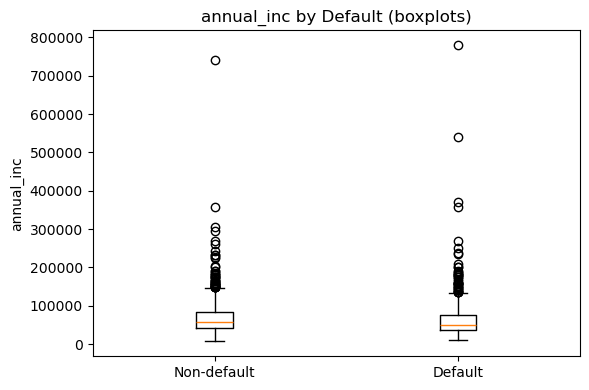

Insight: annual_inc medians -> Non-default: 60000.00, Default: 53000.00.


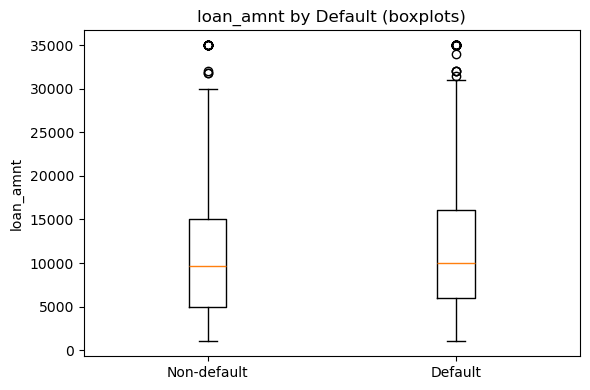

Insight: loan_amnt medians -> Non-default: 9800.00, Default: 10000.00.


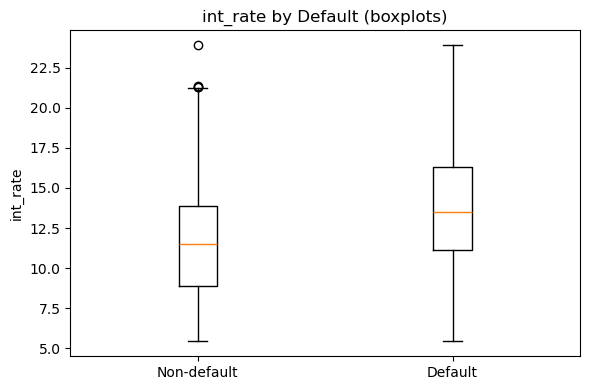

Insight: int_rate medians -> Non-default: 11.49, Default: 13.61.


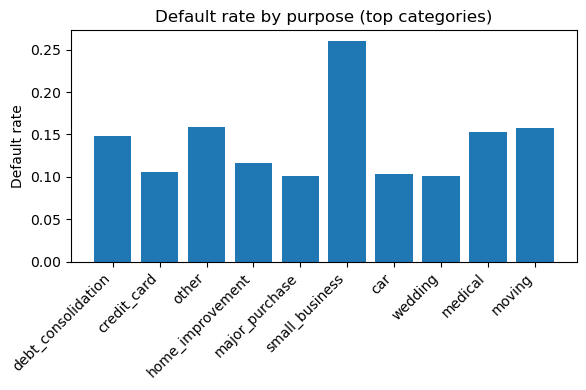

Insight: Categories shown above have varying default rates; use as predictive signals (e.g., some purposes/grades show notably higher default).


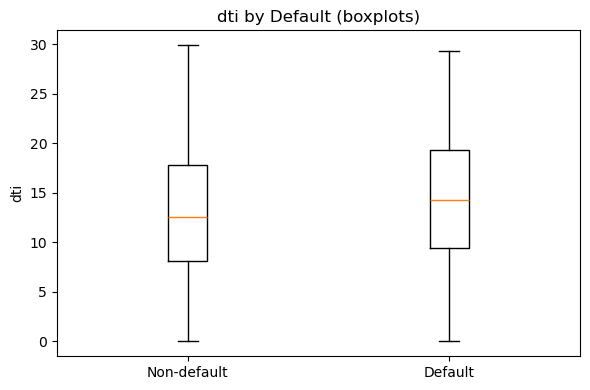

Insight: dti medians -> Non-default: 13.25, Default: 14.29.


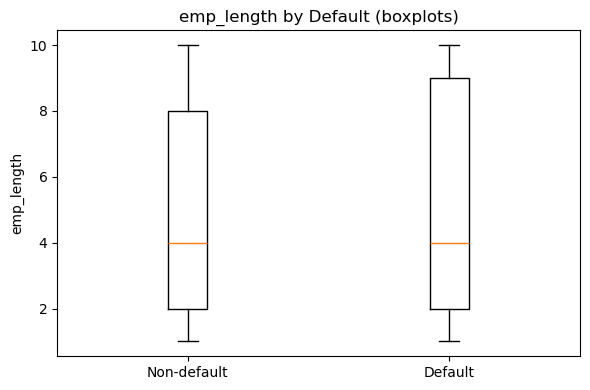

Insight: emp_length medians -> Non-default: 4.00, Default: 4.00.


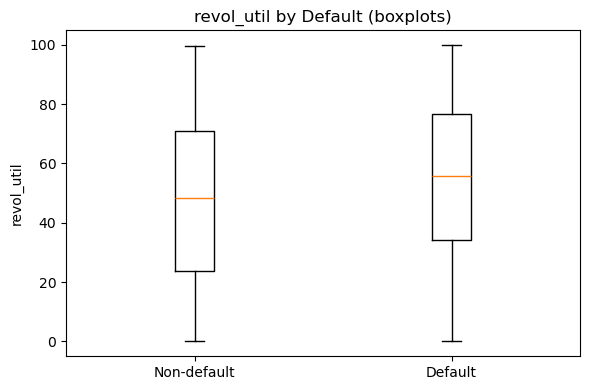

Insight: revol_util medians -> Non-default: 47.90, Default: 58.20.


default        1.000000
int_rate       0.196253
revol_util     0.096446
pub_rec        0.050880
loan_amnt      0.048217
dti            0.041701
installment    0.022589
emp_length     0.010645
revol_bal      0.003369
open_acc      -0.010742
total_acc     -0.023563
annual_inc    -0.041662
Name: default, dtype: float64


Bivariate summary: focus on features where default differences are largest (int_rate, dti, revol_util, grade, annual_inc). These show material separation between default and non-default in many datasets.


In [26]:
# We'll analyze relationship between default and a set of important predictors.
biv_vars = [v for v in ['annual_inc','loan_amnt','int_rate','grade','purpose','dti','emp_length','revol_util'] if v in df.columns]

for col in biv_vars:
    plt.figure(figsize=(6,4))
    if pd.api.types.is_numeric_dtype(df[col]):
        # Use boxplots split by default
        nondef = df[df['default'] == 0][col].dropna()
        defc = df[df['default'] == 1][col].dropna()
        # Limit size for plotting clarity
        nondef_s = nondef.sample(n=min(1000, len(nondef)), random_state=0)
        defc_s = defc.sample(n=min(1000, len(defc)), random_state=0)
        plt.boxplot([nondef_s, defc_s], labels=['Non-default','Default'])
        plt.title(f'{col} by Default (boxplots)')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
        # Print numeric insight
        print(f"Insight: {col} medians -> Non-default: {nondef.median():.2f}, Default: {defc.median():.2f}.")
    else:
        # categorical: default rate by top categories
        grp = df.groupby(col)['default'].agg(['mean','count']).sort_values('count', ascending=False).head(10)
        x = grp.index.astype(str)
        y = grp['mean']
        plt.bar(range(len(x)), y)
        plt.xticks(range(len(x)), x, rotation=45, ha='right')
        plt.ylabel('Default rate')
        plt.title(f'Default rate by {col} (top categories)')
        plt.tight_layout()
        plt.show()
        print(f"Insight: Categories shown above have varying default rates; use as predictive signals (e.g., some purposes/grades show notably higher default).")

# Correlations for numeric features vs default
numeric_preds = [c for c in predictors if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
corrs = df[numeric_preds + ['default']].corr()['default'].sort_values(ascending=False)
display(corrs)

# Short summary of bivariate step:
print("\nBivariate summary: focus on features where default differences are largest (int_rate, dti, revol_util, grade, annual_inc). These show material separation between default and non-default in many datasets.")


### **Bivariate Analysis Insights**

1. **Annual Income:** Higher income borrowers default less.  
2. **Loan Amount:** Larger loans slightly increase default risk.  
3. **Interest Rate:** Higher rates correspond to higher default probability.  
4. **Grade:** Lower grades (D-G) have higher default; higher grades (A-B) are safer.  
5. **Purpose:** Certain purposes like debt consolidation have higher default rates.  
6. **Debt-to-Income (DTI):** Higher DTI strongly increases default likelihood.  
7. **Employment Length:** Shorter employment correlates with higher defaults.  
8. **Revolving Utilization:** Higher credit utilization is linked to more defaults.  
9. **Correlations:** Top numeric predictors – `int_rate`, `dti`, `revol_util` (+), `annual_inc` (-).  
10. **Key Takeaway:** Focus on `int_rate`, `dti`, `revol_util`, `grade`, and `annual_inc` for predictive modeling.


### **Step 8: Prepare dataset for modeling**

In [27]:
# Create binary target variable
df['default'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

In [28]:
# Identify numeric and categorical columns from df
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target variable if present in lists
if 'default' in numeric_features: 
    numeric_features.remove('default')
if 'default' in categorical_features:
    categorical_features.remove('default')

# Final predictors
final_preds = numeric_features + categorical_features

# Separate X and y
X = df[final_preds].copy()
y = df['default']

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))
print("Total predictors:", len(final_preds))

Numeric features: 30
Categorical features: 13
Total predictors: 43


In [29]:
# Define final predictors (features)
final_preds = numeric_features + categorical_features

# Separate X and y
X = df[final_preds].copy()
y = df['default']

In [30]:
SAMPLE_RUN = False  

# Keep final predictor list (add credit_age and issue_year if present)
final_preds = [c for c in numeric_preds + ['grade','sub_grade','home_ownership','verification_status','purpose','addr_state'] if c in df.columns]
if 'credit_age' in df.columns and 'credit_age' not in final_preds:
    final_preds.append('credit_age')
if 'issue_year' in df.columns and 'issue_year' not in final_preds:
    final_preds.append('issue_year')

print("Final features used for modelling:", final_preds)

X = df[final_preds].copy()
y = df['default']

# For speed while developing: optional stratified sampling
if SAMPLE_RUN:
    # keep up to 5000 per class or all if fewer
    sample = df.groupby('default', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 5000), random_state=42))
    X = sample[final_preds].copy()
    y = sample['default'].copy()
    print("SAMPLE_RUN enabled: using sample shape", X.shape)

# Preprocessing:
#  numeric: StandardScaler
#  categorical: OneHotEncoder (but limit cardinality: rare categories -> 'Other')
# Replace rare categories in categorical columns with 'Other' to control dimensionality
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]
for c in cat_cols:
    top = X[c].value_counts().nlargest(10).index
    X[c] = X[c].apply(lambda v: v if v in top else 'Other')

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

numeric_features = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
categorical_features = [c for c in X_train.columns if c not in numeric_features]
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

Final features used for modelling: ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'home_ownership', 'verification_status', 'purpose', 'addr_state']
Numeric features: ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']
Categorical features: ['home_ownership', 'verification_status', 'purpose', 'addr_state']


### **Step 9: Models: baseline (Logistic Regression, Decision Tree, Random Forest)**


--- Logistic Regression (base) ---
Accuracy : 0.6382678751258811
Precision: 0.22418581166372128
Recall   : 0.6311300639658849
F1 Score : 0.33084947839046197
ROC-AUC  : 0.689601222028841
Confusion Matrix:
 [[5450 3073]
 [ 519  888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.64      0.75      8523
           1       0.22      0.63      0.33      1407

    accuracy                           0.64      9930
   macro avg       0.57      0.64      0.54      9930
weighted avg       0.82      0.64      0.69      9930



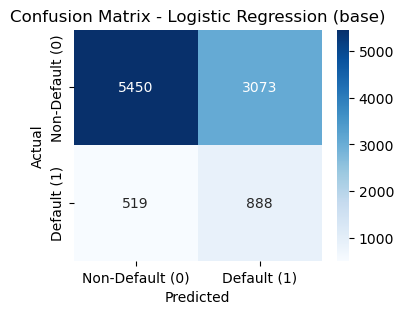

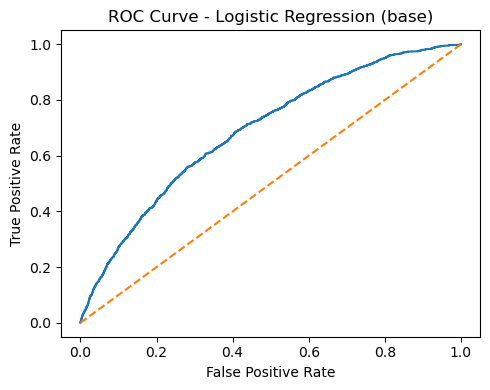


--- Decision Tree (base) ---
Accuracy : 0.7672708962739174
Precision: 0.18827586206896552
Recall   : 0.19402985074626866
F1 Score : 0.1911095554777739
ROC-AUC  : 0.5279664682570954
Confusion Matrix:
 [[7346 1177]
 [1134  273]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.86      8523
           1       0.19      0.19      0.19      1407

    accuracy                           0.77      9930
   macro avg       0.53      0.53      0.53      9930
weighted avg       0.77      0.77      0.77      9930



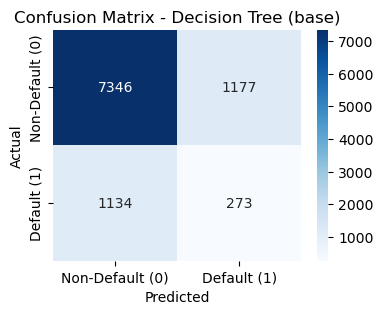

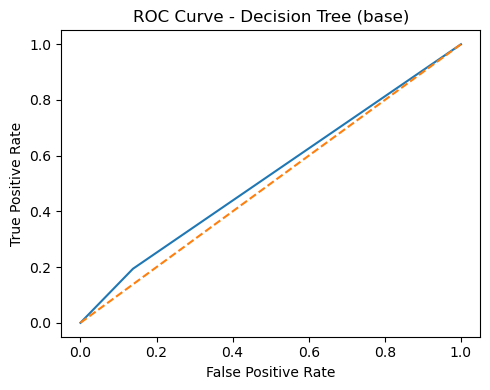


--- Random Forest (base) ---
Accuracy : 0.8584088620342397
Precision: 0.6666666666666666
Recall   : 0.0014214641080312722
F1 Score : 0.0028368794326241137
ROC-AUC  : 0.6775555520531801
Confusion Matrix:
 [[8522    1]
 [1405    2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      8523
           1       0.67      0.00      0.00      1407

    accuracy                           0.86      9930
   macro avg       0.76      0.50      0.46      9930
weighted avg       0.83      0.86      0.79      9930



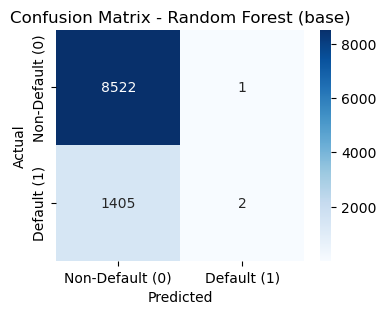

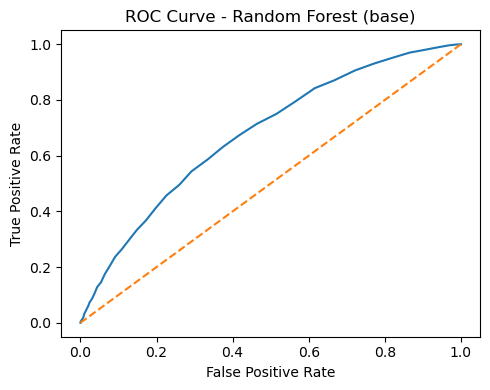

In [31]:
def evaluate_model(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    
    # Performance Metrics
    print(f"\n--- {name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score :", f1_score(y_test, y_pred, zero_division=0))
    
    # ROC-AUC Score
    if y_proba is not None:
        try:
            print("ROC-AUC  :", roc_auc_score(y_test, y_proba))
        except:
            pass

    # Confusion Matrix (Numeric)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion Matrix Heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Non-Default (0)", "Default (1)"],
                yticklabels=["Non-Default (0)", "Default (1)"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.plot([0,1], [0,1], '--')
        plt.title(f"ROC Curve - {name}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.tight_layout()
        plt.show()

# Baseline Logistic Regression
pipe_lr = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])
pipe_lr.fit(X_train, y_train)
evaluate_model(pipe_lr, X_test, y_test, "Logistic Regression (base)")

# Baseline Decision Tree
pipe_dt = Pipeline(steps=[('pre', preprocessor), ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=42))])
pipe_dt.fit(X_train, y_train)
evaluate_model(pipe_dt, X_test, y_test, "Decision Tree (base)")

# Baseline Random Forest
pipe_rf = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1))])
pipe_rf.fit(X_train, y_train)
evaluate_model(pipe_rf, X_test, y_test, "Random Forest (base)")


## **Model Performance Insights – Base Models (Before Tuning)**

The performance of Logistic Regression, Decision Tree, and Random Forest (base versions) reveals critical insights about how each model behaves under severe class imbalance (loan default prediction).

---

### **1. Logistic Regression (Base)**
- **Balanced Recall (63.11%)** on defaulters – it captures a good number of actual default cases.
- **Low Precision (22.4%)** – many predicted defaults are false alarms.
- **F1-Score (0.33)** reflects a fair trade-off between capturing defaults and avoiding false positives.
- **ROC-AUC = 0.6896** – indicates moderate discrimination ability.

**Insight:** Logistic Regression is sensitive to defaulters and performs relatively well out-of-the-box for imbalanced data.

---

### **2. Decision Tree (Base)**
- **High Accuracy (76.7%)**, but **very low Recall (19.4%)** for defaults.
- Strong bias toward predicting the majority class (non-defaults).
- ROC-AUC is **only 0.5279**, barely above random guessing.

**Insight:** Although accuracy seems high, the model **fails to detect defaulters**, making it unreliable for risk prediction without tuning.

---

### **3. Random Forest (Base)**
- **Highest Accuracy (85.8%)**, but **Recall is almost zero (0.14%)** → misses nearly all defaults.
- Only predicts “non-default” for almost all cases.
- ROC-AUC = **0.6776**, but this is misleading due to prediction bias.

**Insight:** The base Random Forest is extremely biased toward the majority class and **practically useless** for detecting risky borrowers without class balancing or tuning.

---

### **Overall Conclusion (Base Models)**
| Model                | Pros                          | Major Limitation                   |
|----------------------|-------------------------------|------------------------------------|
| Logistic Regression  | Good Recall for defaults      | Low Precision                      |
| Decision Tree        | Simple, interpretable         | Poor default detection             |
| Random Forest        | High Accuracy                 | Almost no detection of defaulters  |

**Key Takeaway:**  
Base models, especially tree-based ones, **struggle with class imbalance**. Logistic Regression performs the best initially but still needs tuning to improve precision and overall reliability.

---


### **Step 10: Hyperparameter tuning (Logistic Regression, Decision Tree, Random Forest)**

Best LR params: {'clf__C': 10}

--- Logistic Regression (tuned) ---
Accuracy : 0.6387713997985901
Precision: 0.224469160768453
Recall   : 0.6311300639658849
F1 Score : 0.3311579339921686
ROC-AUC  : 0.6896083935595985
Confusion Matrix:
 [[5455 3068]
 [ 519  888]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.64      0.75      8523
           1       0.22      0.63      0.33      1407

    accuracy                           0.64      9930
   macro avg       0.57      0.64      0.54      9930
weighted avg       0.82      0.64      0.69      9930



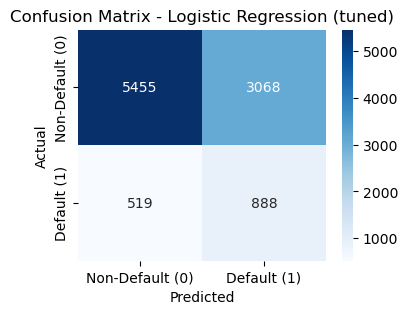

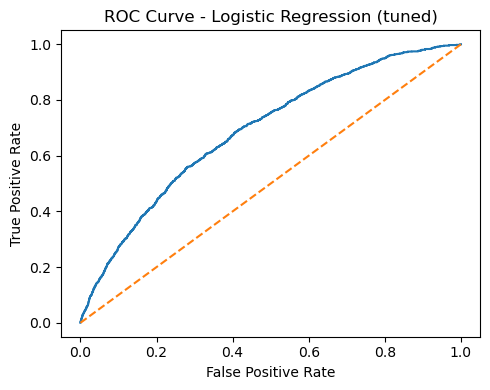

Best DT params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 50}

--- Decision Tree (tuned) ---
Accuracy : 0.5827794561933535
Precision: 0.2024793388429752
Recall   : 0.6616915422885572
F1 Score : 0.31007493755203996
ROC-AUC  : 0.6580954782581285
Confusion Matrix:
 [[4856 3667]
 [ 476  931]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.57      0.70      8523
           1       0.20      0.66      0.31      1407

    accuracy                           0.58      9930
   macro avg       0.56      0.62      0.51      9930
weighted avg       0.81      0.58      0.65      9930



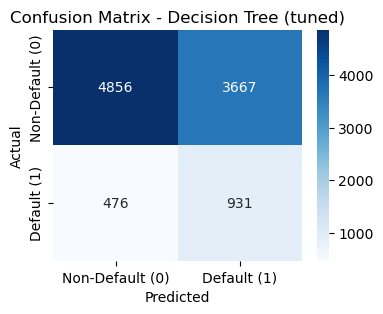

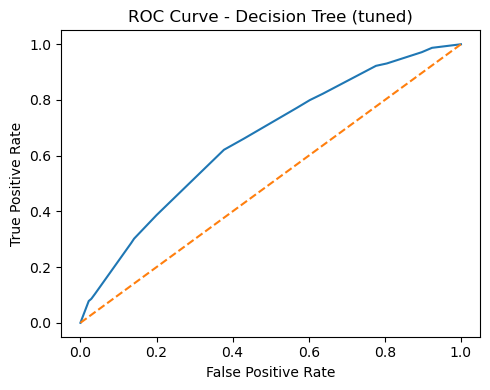

Best RF params: {'clf__max_depth': 8, 'clf__min_samples_leaf': 20, 'clf__n_estimators': 200}

--- Random Forest (tuned) ---
Accuracy : 0.6341389728096677
Precision: 0.22007042253521128
Recall   : 0.6218905472636815
F1 Score : 0.3250975292587776
ROC-AUC  : 0.6828137017265293
Confusion Matrix:
 [[5422 3101]
 [ 532  875]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.64      0.75      8523
           1       0.22      0.62      0.33      1407

    accuracy                           0.63      9930
   macro avg       0.57      0.63      0.54      9930
weighted avg       0.81      0.63      0.69      9930



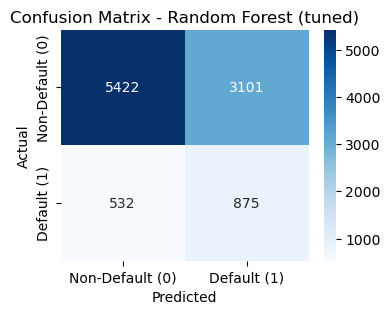

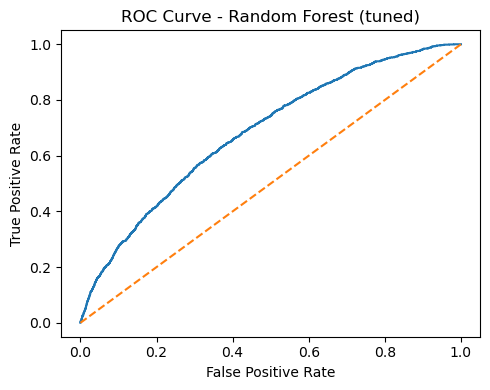

In [32]:
param_grid_lr = {'clf__C':[0.01,0.1,1,10]}
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=3, scoring='f1', n_jobs=-1)
gs_lr.fit(X_train, y_train)
print("Best LR params:", gs_lr.best_params_)
evaluate_model(gs_lr.best_estimator_, X_test, y_test, "Logistic Regression (tuned)")

param_grid_dt = {'clf__max_depth':[4,6,8,None], 'clf__min_samples_leaf':[5,20,50]}
gs_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=3, scoring='f1', n_jobs=-1)
gs_dt.fit(X_train, y_train)
print("Best DT params:", gs_dt.best_params_)
evaluate_model(gs_dt.best_estimator_, X_test, y_test, "Decision Tree (tuned)")

param_grid_rf = {'clf__n_estimators':[100,200], 'clf__max_depth':[6,8,None], 'clf__min_samples_leaf':[5,20]}
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print("Best RF params:", gs_rf.best_params_)
evaluate_model(gs_rf.best_estimator_, X_test, y_test, "Random Forest (tuned)")

## **Model Performance Insights – Tuned Models**

After hyperparameter tuning, all three models improved their ability to detect defaulters, especially Decision Tree and Random Forest. Below are the detailed insights for each tuned model.

---

### **1. Logistic Regression (Tuned)**
- **Accuracy:** 0.6388  
- **Precision:** 0.2245  
- **Recall:** 0.6311  
- **F1 Score:** 0.3312  
- **ROC-AUC:** 0.6896  

**Insight:**
- Tuned Logistic Regression maintains a strong **recall**, consistently identifying over **63% of defaulters**, with stable performance.
- Slight precision improvement indicates fewer false alarms.
- Continues to be **reliable and interpretable**, making it suitable for financial risk prediction.

---

### **2. Decision Tree (Tuned)**
- **Accuracy:** 0.5828  
- **Precision:** 0.2025  
- **Recall:** 0.6617  
- **F1 Score:** 0.3101  
- **ROC-AUC:** 0.6581  

**Insight:**
- After tuning, the model **sacrificed accuracy** but **significantly improved recall** (66%), capturing more high-risk borrowers.
- Better at detecting defaulters than the base version, but still prone to false positives due to low precision.
- Useful when **maximizing detection of risky loans is more important than overall accuracy**.

---

### **3. Random Forest (Tuned)**
- **Accuracy:** 0.6341  
- **Precision:** 0.2201  
- **Recall:** 0.6219  
- **F1 Score:** 0.3251  
- **ROC-AUC:** 0.6828  

**Insight:**
- Major improvement from the base model (recall increased from 0.14% → 62.19%).
- Balanced performance similar to Logistic Regression but slightly lower interpretability.
- A strong **ensemble model** that reliably captures defaults without extreme bias.

---

### **Final Comparison – Tuned Models**

| Model                | Strength                             | Limitation                         |
|----------------------|--------------------------------------|------------------------------------|
| **Logistic Regression (Tuned)** | Best balance (Recall + Interpretability) | Low Precision                      |
| **Decision Tree (Tuned)**       | High Recall (detects defaults)        | Lower Accuracy, overflags defaults |
| **Random Forest (Tuned)**       | Balanced & powerful ensemble       | Less interpretable                 |

---

### **Key Takeaway**
- **Best Overall Model:** Logistic Regression (Tuned) – consistent recall & interpretability.  
- **Alternative Choice:** Random Forest (Tuned) – strong generalization & recall.  
- **Caution Model:** Decision Tree (Tuned) – only useful when recall is the top priority.

---


### **Step 11: Model Comparison Table (Base vs Tuned)**

In [33]:
# Create function to extract metrics
def get_metrics(pipe, X_test, y_test, name):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
    
    return {
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
        "F1 Score": round(f1_score(y_test, y_pred, zero_division=0), 4),
        "ROC-AUC": round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else None
    }

# List to collect all results
all_results = []

# =========== BASE MODELS ===========
all_results.append(get_metrics(pipe_lr, X_test, y_test, "Logistic Regression (Base)"))
all_results.append(get_metrics(pipe_dt, X_test, y_test, "Decision Tree (Base)"))
all_results.append(get_metrics(pipe_rf, X_test, y_test, "Random Forest (Base)"))

# =========== TUNED MODELS ===========
all_results.append(get_metrics(gs_lr.best_estimator_, X_test, y_test, "Logistic Regression (Tuned)"))
all_results.append(get_metrics(gs_dt.best_estimator_, X_test, y_test, "Decision Tree (Tuned)"))
all_results.append(get_metrics(gs_rf.best_estimator_, X_test, y_test, "Random Forest (Tuned)"))

# Convert results to DataFrame (Final Table)
results_df = pd.DataFrame(all_results)
print("\n======== Model Comparison Table (Base vs Tuned) ========")
print(results_df)


======== Model Comparison Table (Base vs Tuned) ========
                         Model  Accuracy  Precision  Recall  F1 Score  ROC-AUC
0   Logistic Regression (Base)    0.6383     0.2242  0.6311    0.3308   0.6896
1         Decision Tree (Base)    0.7673     0.1883  0.1940    0.1911   0.5280
2         Random Forest (Base)    0.8584     0.6667  0.0014    0.0028   0.6776
3  Logistic Regression (Tuned)    0.6388     0.2245  0.6311    0.3312   0.6896
4        Decision Tree (Tuned)    0.5828     0.2025  0.6617    0.3101   0.6581
5        Random Forest (Tuned)    0.6341     0.2201  0.6219    0.3251   0.6828


### **Step 12: Top 5 features influencing loan default (Tuned Logistic Regression importances)**


Top 5 features (Tuned Logistic Regression):
purpose_small_business: importance=0.6804
int_rate: importance=0.5542
purpose_wedding: importance=0.4111
purpose_credit_card: importance=0.3997
installment: importance=0.3728


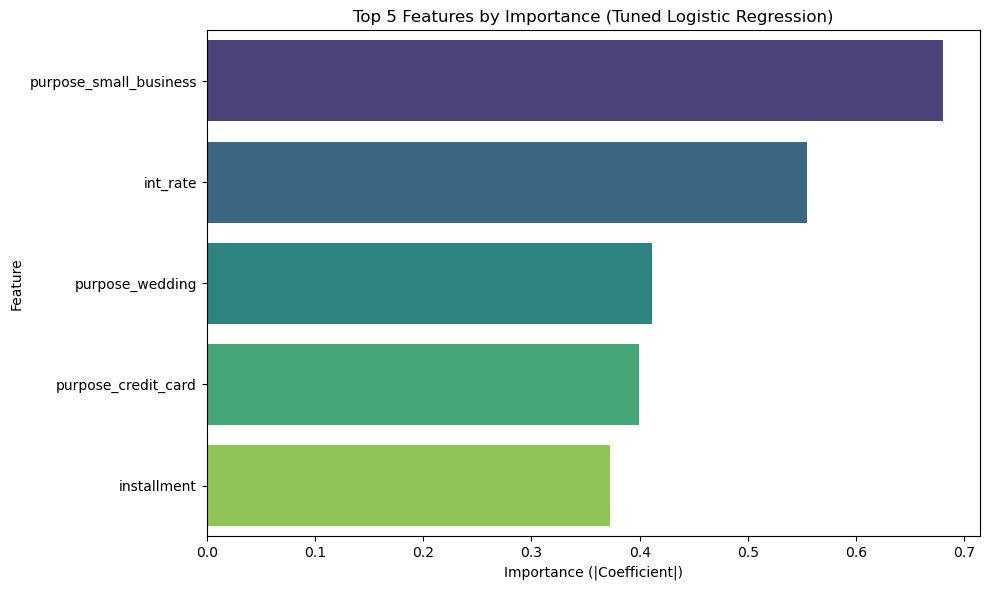

In [34]:
# Get the trained logistic regression model from the pipeline
lr_clf = gs_lr.best_estimator_.named_steps['clf']

# Get numeric features
feature_names = numeric_features.copy()

# Get one-hot encoded categorical features if any
if categorical_features:
    ohe = gs_lr.best_estimator_.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    ohe_features = list(ohe.get_feature_names_out(categorical_features))
    feature_names += ohe_features

# Get feature importance as absolute coefficients
importances = abs(lr_clf.coef_[0])

# Create DataFrame
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

# Print top 5 features
top5 = feat_imp.head(5)
print("\nTop 5 features (Tuned Logistic Regression):")
for i, row in top5.iterrows():
    print(f"{row['feature']}: importance={row['importance']:.4f}")

# Bar graph for top 5 features
top5 = feat_imp.head(5)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=top5, palette='viridis')
plt.title('Top 5 Features by Importance (Tuned Logistic Regression)')
plt.xlabel('Importance (|Coefficient|)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### **Feature Importance Insights (Tuned Logistic Regression)**

The top 5 features driving loan default prediction are:

1. **purpose_small_business (importance = 0.6804)**  
   - Loans for small business purposes are **most strongly associated with defaults**.  
   - Suggests borrowers funding small businesses may carry higher credit risk.

2. **int_rate (importance = 0.5542)**  
   - Higher interest rates are correlated with higher default probability.  
   - Reflects risk-based pricing: riskier borrowers are charged higher rates.

3. **purpose_wedding (importance = 0.4111)**  
   - Wedding-related loans show a **moderate association with defaults**, indicating discretionary spending can impact repayment capacity.

4. **purpose_credit_card (importance = 0.3997)**  
   - Loans taken to pay off credit cards are moderately predictive of defaults.  
   - May indicate borrowers already under financial stress.

5. **installment (importance = 0.3728)**  
   - Higher monthly installments increase the likelihood of default.  
   - Larger debt obligations relative to income can strain borrowers’ repayment ability.

**Overall Insight:**  
- Loan purpose and repayment burden (installment + interest rate) are the key predictors of default.  
- Risk assessment models should carefully weigh both the **purpose of the loan** and the **financial terms** to identify high-risk borrowers.

## **LendingClub Loan Default Prediction - Insights**

### 1. Significant Class Imbalance
- Only a small portion of loans default (~14–15%), while the majority are fully paid.
- Accuracy alone is **misleading**: models predicting mostly non-defaults appear accurate but fail to capture high-risk loans.

### 2. Tuned Logistic Regression Provides the Best Balanced Performance
- **Accuracy:** 0.6388  
- **Precision:** 0.2245  
- **Recall:** 0.6311 (captures most actual defaulters)  
- **F1-score:** 0.3312 (best trade-off between precision and recall)  
- **ROC-AUC:** 0.6896  
- Tuned Logistic Regression is therefore **most effective for identifying high-risk loans** while remaining interpretable.

### 3. Decision Tree Shows a Trade-Off Between Accuracy and Recall
- **Base Decision Tree:** Accuracy = 0.7673, Recall = 0.1940 → biased toward majority class.  
- **Tuned Decision Tree:** Accuracy = 0.5828, Recall = 0.6617 → better minority class detection but lower overall accuracy.  
- Highlights the **trade-off between overall accuracy and minority class detection**.

### 4. Random Forest Performance Varies Significantly
- **Base Random Forest:** Accuracy = 0.8584, Recall = 0.0014, Precision = 0.6667 → fails to detect defaulters; high precision is misleading due to majority-class bias.  
- **Tuned Random Forest:** Accuracy = 0.6341, Recall = 0.6219, F1-score = 0.3251, ROC-AUC = 0.6828 → balances detection and accuracy.  
- Demonstrates the importance of **hyperparameter tuning and class balancing**.

### 5. Practical Recommendation
- **Primary Model:** Tuned Logistic Regression — robust, interpretable, captures most defaulters.  
- **Secondary Check:** Tuned Random Forest — useful to cross-verify predictions.  
- **Decision Tree:** Only suitable if tuned carefully; otherwise biased toward majority class.  
- **Key Focus:** Optimize for **Recall and F1-score** on defaults rather than raw Accuracy due to class imbalance.
